# Resample Algorithms

#### Resample Algorithms describe how cell values of one raster are resampled into another raster. The new raster can have the same resolution (usually slightly shifted raster), a smaller or a coarser resolution.
#### The most relevant application is resampling finer resolution input rasters to coarser resolution putput rasters. This may be needed when your analysis resolution is coarser than the input raster resolution, but also if you need to reduce data size in a preprocessing step!

### NOTE: This exercise does NOT have a solution, the task here is only to understand and execute this script carefully - it will prepare you for future challenges when doing your own land eligibility assessments!

In [1]:
# import required packages
import glaes as gl
import geokit as gk
import pathlib
import os

## Input parameters

In [2]:
# define our study region
region='NER.4_1' # must be a GID_1 region, here "Maradi" in Niger

# define the analysis resolution
resolution=100

In [3]:
# extract country from region string
country = region[:3] # this reduces the string to the first 3 characters, since all GID region codes contain the alpha-3 country code at the beginning
country

'NER'

## Determine paths

In [4]:
# define some relative paths for exclusion datasets, paths relative to data folder, with a COUNTRY variable to replace later
region_shp="region_shapefiles//COUNTRY_gadm_shapes_GID_level_1.shp"

country_shp="region_shapefiles//COUNTRY_gadm_shapes_GID_level_0.shp"

WSF2019_tif="exclusion_datasets//WSF2019//COUNTRY//REGION_extract_WSF2019_clipped.tif"

In [5]:
# just like before, we determine our datafolder, here in a one liner
data_basefolder = os.path.join(pathlib.Path().cwd().parent.parent, 'data')
print(data_basefolder)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data


In [6]:
# from the global region shapefile, extract only the row for the selected region
region_df = gk.vector.extractFeatures(
    source=os.path.join(data_basefolder, region_shp.replace("COUNTRY", country)),
    where=f"GID_1='{region}'",
    )
region_df

,geom,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
0,"POLYGON ((7.16382504 13.04490757,7.15807676 13...",NER,Niger,NER.4_1,Maradi,None,None,Département,Department,None,NE.MA


<Axes: >

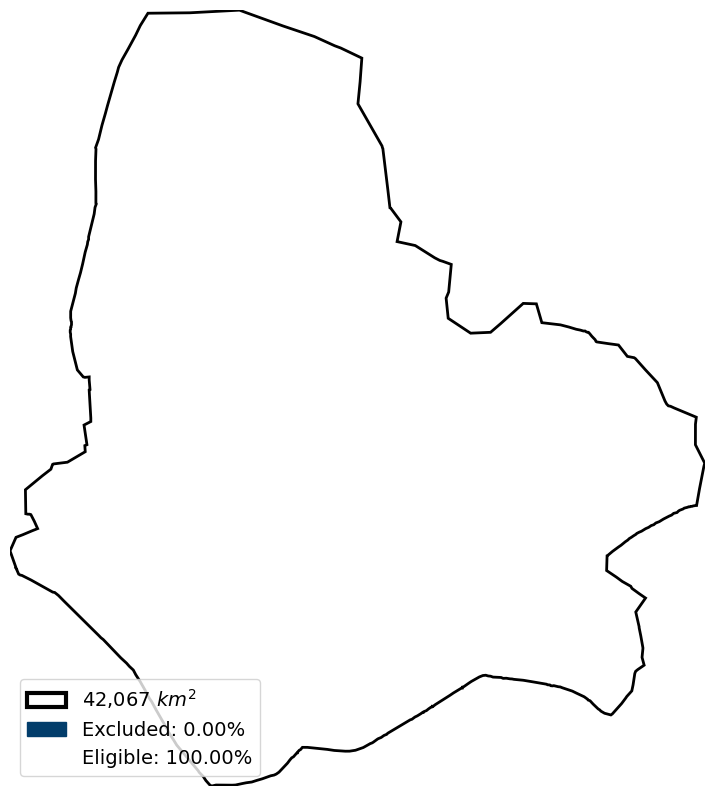

In [7]:
# we create an Exclusion Calculator object
ec = gl.ExclusionCalculator(
    region=os.path.join(data_basefolder, region_shp.replace("COUNTRY", country)),
    where=f"GID_1='{region}'",
    resolution=resolution,
    srs=gk.srs.EPSG3857,
)
ec.draw()

In [8]:
# let us save a copy of this "empty" ec object to ply around a bit
from copy import copy
ec_empty = copy(ec)

## Try different resample algorithms

Memory useage during calc: 1171.05078125 MB
Excluded area share [%] 0.002305819126789288


<Axes: >

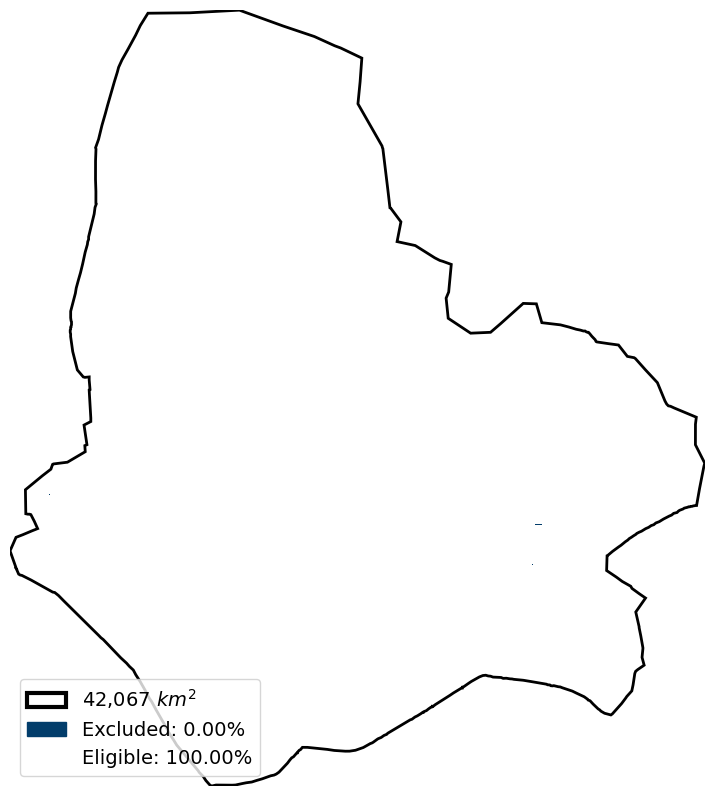

In [9]:
# first, we try the "min" resample algorithm - always the minimum value in the input raster (ca. 10m resolution) will be chosen for each cell in analysis resolution (100m)
# min resampleAlg will return zero hence if not ALL sub cells are filled with 255 built up values
ec.excludeRasterType(
    source=os.path.join(data_basefolder, WSF2019_tif.replace("COUNTRY", country).replace("REGION", region)),
    value="255",
    resampleAlg='min',
)

# As shown in the plot below, we only excluded a super small percentage of our area (100% - remaining availability)
print("Excluded area share [%]", 100 - ec.percentAvailable) # exclusion in %

# we see that only very few cells are COMPETELY filled with built up area
ec.draw()

Memory useage during calc: 1215.15625 MB


<Axes: >

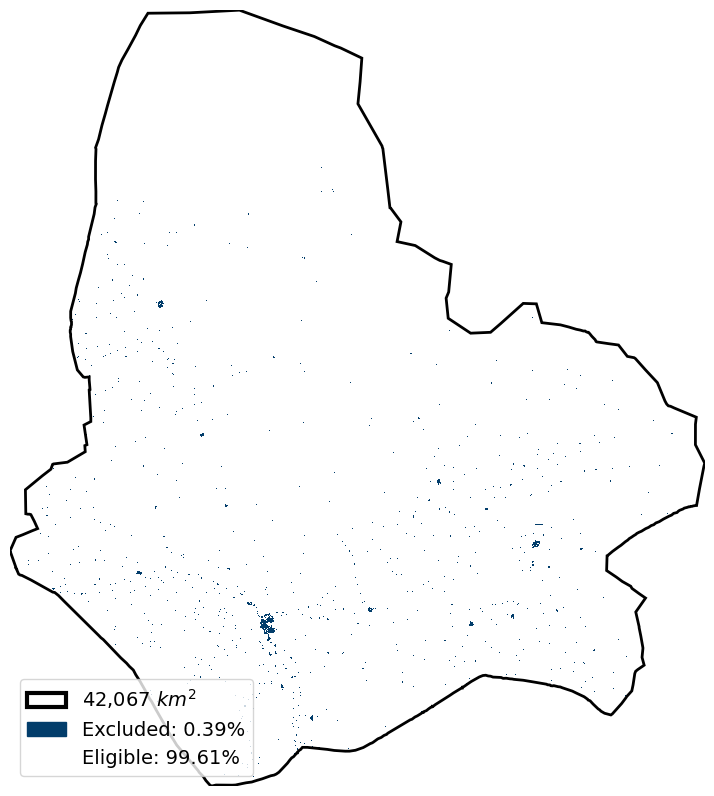

In [10]:
# Now we try the "med" algorithm - that means at least 50% (median) of the input sub cells must be above the value
# (first reset the ec object by replacing it with a copy of the "empty" ec_empty object)
ec=copy(ec_empty)

# since we have values of 0 and 255 only, this hence excludes only cells where at least 50% of the sub cells are built up
ec.excludeRasterType(
    source=os.path.join(data_basefolder, WSF2019_tif.replace("COUNTRY", country).replace("REGION", region)),
    value="255",
    resampleAlg='med',
)

# we see that the exclusion percentage is much higher now!
ec.draw()

Memory useage during calc: 1034.32421875 MB
Excluded area share [%] 5.5472065357848805


<Axes: >

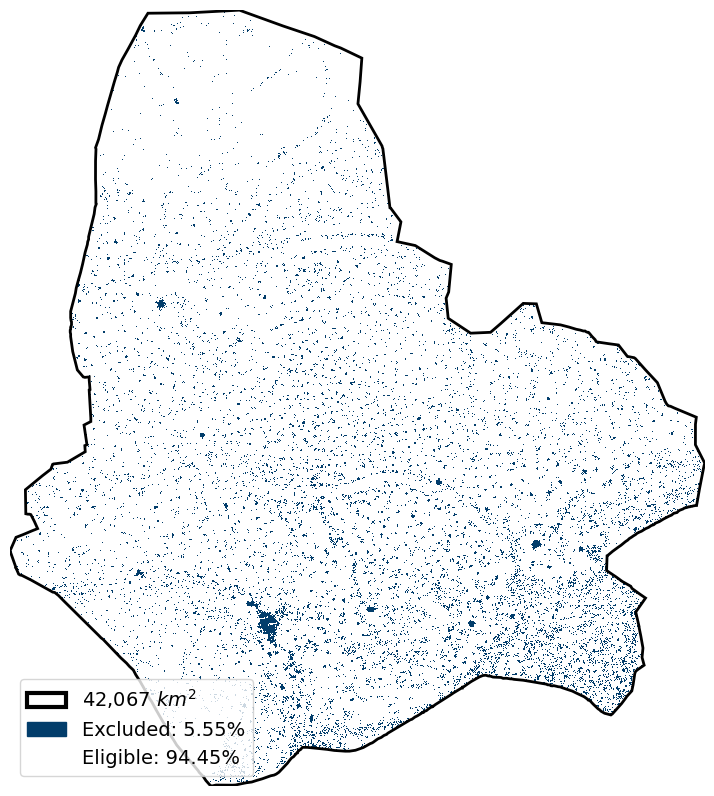

In [11]:
# Now we try the "max" algorithm - that means that the maximum value of all sub cells is considered
# since our input raster has values of 0 and 255, max means that a cell is considered ineligible, if at least ONE sub cell is ineligible
# this is meaningful for houses, when every single house shall be considered, but maybe not for other exclusions like slope etc.

# (first reset the ec object by replacing it with a copy of the "empty" ec_empty object)
ec=copy(ec_empty)

ec.excludeRasterType(
    source=os.path.join(data_basefolder, WSF2019_tif.replace("COUNTRY", country).replace("REGION", region)),
    value="255",
    resampleAlg='max',
)

# As shown in the plot below, we exclude much more cells now
print("Excluded area share [%]", 100 - ec.percentAvailable) # exclusion in %

# now we see that more than half of the cells are excluded - more than 100x the exclusion for the min value!
ec.draw()

Memory useage during calc: 1088.76953125 MB


<Axes: >

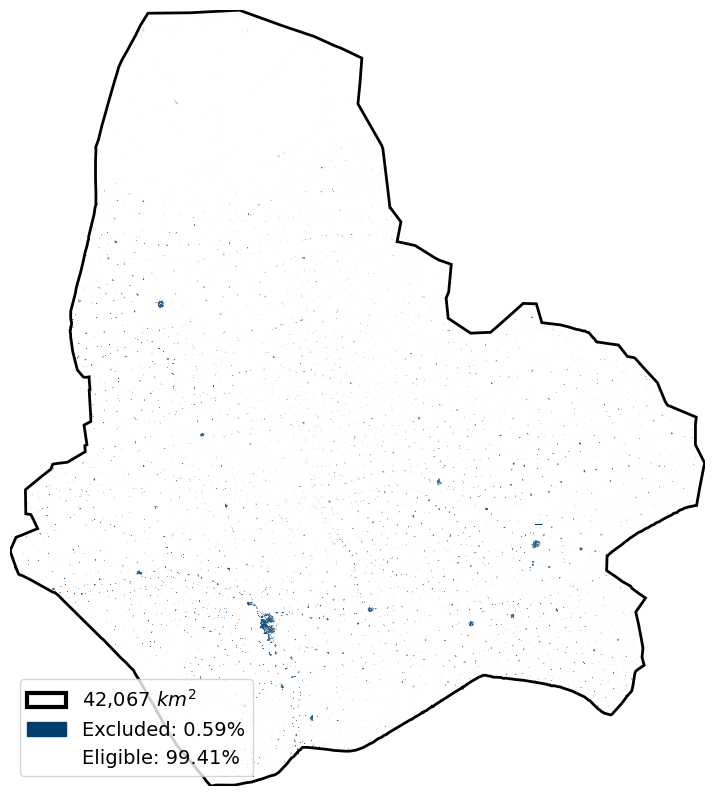

In [12]:
# NOTE: The default algorithm in glaes is "bilinear" - this interpolates neighbouring input cells and returns a value somewhere between the surrounding input values

# (first reset the ec object by replacing it with a copy of the "empty" ec_empty object)
ec=copy(ec_empty)

ec.excludeRasterType(
    source=os.path.join(data_basefolder, WSF2019_tif.replace("COUNTRY", country).replace("REGION", region)),
    value="255",
    # resampleAlg='bilinear', # NO resampleAlg for excludeRasterType() means 'bilinear' by default
)

# NOTE: This algorithm is very suitable for continuous rasters such as wind speed etc. - but NOT for categorical rasters!!
# Example: It is reasonable that the wind speed somwhere in the middle between a cell with 7m/s and 5m/s will be around 6m/s
# It makes NO sense though if I have two categories like here: 0 is non-built-up, 255 is built-up. The value 127.5 in the middle between the two would have no meaning!

# as a result, we can see some blurry values in between eligible and not eligible which make limited sense here - so ALWAYS define a suitable resampleAlg when exclusing rasters!
ec.draw()

# NOTE: This is NOT a good solution for categorical rasters such as settlements here!

## Apply the resampleAlg to a warped raster
#### Warping rasters means to warp an input raster to a new raster context, which can mean different resolution, extent, srs etc.
#### It can be very helpful to reduce input data size, clip to your study region or reduce processing effort by coarser resolution
#### Howver, always know exactly what the impact of your adaptations is (see the examples above)!

In [13]:
# a quick way to warp to your study region is a regionmask, another geokit class
# we will therefore create a RegionMask object rm from a region geometry
# have a look at the expected inputs for geokit.RegionMask.fromGeom() first
gk.RegionMask.fromGeom?

Signature:
gk.RegionMask.fromGeom(
    geom,
    pixelRes=100,
    srs='europe_m',
    start_raster=None,
    extent=None,
    padExtent=None,
    attributes=None,
    **k,
)
Docstring:
Make a RasterMask from a given geometry

Parameters:
-----------
geom : ogr-Geomertry or str
    A geometric representation of the RegionMask's region
    * If a string is given, geokit.geom.convertWKT(geom, srs) is called
      to convert it to an ogr.Geometry

pixelRes : float or tuple
    The RegionMask's native pixel resolution(s)
    * If float : A pixel size to apply to both the X and Y dimension
    * If (float float) : An X-dimension and Y-dimension pixel size

srs : Anything acceptable to geokit.srs.loadSRS()
    The srs context of the generated RegionMask object
    * This srs is superseded by the srs in an explicitly defined extent
    * The default srs EPSG3035 is only valid for a European context

extent : Extent object
    The geospatial context of the generated region mask
    * The exten

In [14]:
# we first need to extract the region geom (like done before)
# therefore first get the dataframe
region_df = gk.vector.extractFeatures(
    source=os.path.join(data_basefolder, region_shp.replace("COUNTRY", country)),
)
# we now have a dataframe with only one entry, our study country
region_df

,geom,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
0,"POLYGON ((6.72484112 15.42760277,6.69059515 15...",NER,Niger,NER.1_1,Agadez,Agadès,None,Département,Department,None,NE.AG
1,"POLYGON ((11.36603165 13.37211037,11.36313725 ...",NER,Niger,NER.2_1,Diffa,None,None,Département,Department,None,NE.DF
2,"POLYGON ((3.61918306 11.92465782,3.61765599 11...",NER,Niger,NER.3_1,Dosso,None,None,Département,Department,None,NE.DS
3,"POLYGON ((7.16382504 13.04490757,7.15807676 13...",NER,Niger,NER.4_1,Maradi,None,None,Département,Department,None,NE.MA
4,"POLYGON ((2.23391604 13.53053188,2.22839999 13...",NER,Niger,NER.5_1,Niamey,None,None,Communauté Urbaine,Capital District,None,NE.NI
5,"POLYGON ((5.19092989 13.74396038,5.18439102 13...",NER,Niger,NER.6_1,Tahoua,None,None,Département,Department,None,NE.TH
6,"POLYGON ((2.61840796 12.59564686,2.62114501 12...",NER,Niger,NER.7_1,Tillabéry,Tillabéri,None,Département,Department,None,NE.TL
7,"POLYGON ((9.1912899 12.82807064,9.17886353 12....",NER,Niger,NER.8_1,Zinder,None,None,Département,Department,None,NE.ZI


In [15]:
# now let us only extract the row with "our" region
print("'our' region code:", region)
# reduce to only the one row with our regional data, identified by the region code in the "GID_1" column
region_df[region_df["GID_1"]==region]

'our' region code: NER.4_1


,geom,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
3,"POLYGON ((7.16382504 13.04490757,7.15807676 13...",NER,Niger,NER.4_1,Maradi,None,None,Département,Department,None,NE.MA


In [16]:
# now get the region geometry object from the "geom" column entry for this row 
# take the first entry (iloc=0) of the reduced datafrane
region_geom = region_df[region_df["GID_1"]==region]["geom"].iloc[0]

# the region_geom is an osgeo.ogr.Geometry object
region_geom

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7f8ad5092c70> >

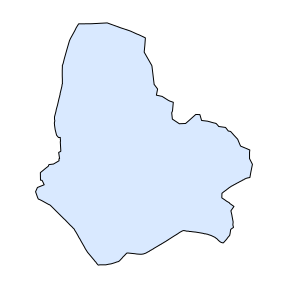

In [17]:
# now we can create the region mask - we choose resolution and srs like we need it for our ec objects above!
rm = gk.RegionMask.fromGeom(
    geom=region_geom,
    pixelRes=resolution,
    srs=gk.srs.EPSG3857,
)
# let us see what we have
rm

In [18]:
# now we warp the raster to our new context - here is the method and its parameters
rm.warp?

Signature:
rm.warp(
    source,
    output=None,
    resolutionDiv=1,
    returnMatrix=True,
    applyMask=True,
    noData=None,
    resampleAlg='bilinear',
    **kwargs,
)
Docstring:
Convenience wrapper for geokit.raster.warp() which automatically sets
'srs', 'bounds', 'pixelWidth', and 'pixelHeight' inputs

Note:
-----
When creating an 'in memory' raster vs one which is saved to disk, a slightly
different algorithm is used which can sometimes add an extra row of pixels. Be
aware of this if you intend to compare value-matricies directly from rasters
generated with this function.

Parameters:
-----------
source : str
    The path to the raster file to warp

output : str; optional
    A path to an output file to write to

resampleAlg : str; optional
    The resampling algorithm to use when warping values
    * Knowing which option to use can have significant impacts!
    * Options are: 'nearesampleAlg=resampleAlg, r', 'bilinear', 'cubic',
      'average'

resolutionDiv : int
    The fa

In [19]:
# define from which raster file you wish to load the data to be warped
source_file=os.path.join(data_basefolder, WSF2019_tif.replace("COUNTRY", country).replace("REGION", region))
source_file

'/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data/exclusion_datasets//WSF2019//NER//NER.4_1_extract_WSF2019_clipped.tif'

In [20]:
# NOTE: The results folder exists in your repo under /student_files/results/, but the files created therein will not be pushed back to git

# this is the current working directory ("student_files/exercises")
cwd = pathlib.Path().cwd()
print(f"Current working directory: {cwd}")

# the results folder is in "student_files/results", so go "2 folders up"
results_folder = os.path.join(os.path.dirname(os.path.dirname(cwd)), 'results')
# make sure folder exists
assert os.path.isdir(results_folder), f"results folder does not exist: '{results_folder}'"

print(f"Results folder:", results_folder)

Current working directory: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/exercises/Unit_04_LandEligibilityForVolatileRenewableEnergySources
Results folder: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results


In [21]:
# now we create an output filepath
# therefore, we remove the last 4 digits from the input filename ('.tif') and replace it with: '_resampled.tif'
# then save this file in the "results" folder so it will not be pushed back to the remote git repo

output_file = os.path.join(
    results_folder, 
    os.path.basename(source_file)[:-4] + '_resampled.tif', # remove the last 4 digits from the input path ('.tif') and replace it with: '_resampled.tif'
)

output_file

'/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results/NER.4_1_extract_WSF2019_clipped_resampled.tif'

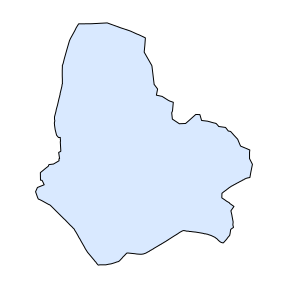

In [22]:
rm

In [23]:
# we now use rm.warp() to warp the source data to the new context
# this means that we do not need to worry about resolution or extent etc. since this is all included in the rm object already
rm.warp(
    source=source_file,
    resampleAlg='max', # choose max as resample algorithm as we wish to determine every cell as built-up with at least a single building!
    output=output_file, # the warped data will be saved to disk as a raster file here
)

# NOTE: This may take very long depending on the file size!

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

AxHands(ax=<Axes: >, handles=[<matplotlib.patches.PathPatch object at 0x7f8ad47876a0>], cbar=None)

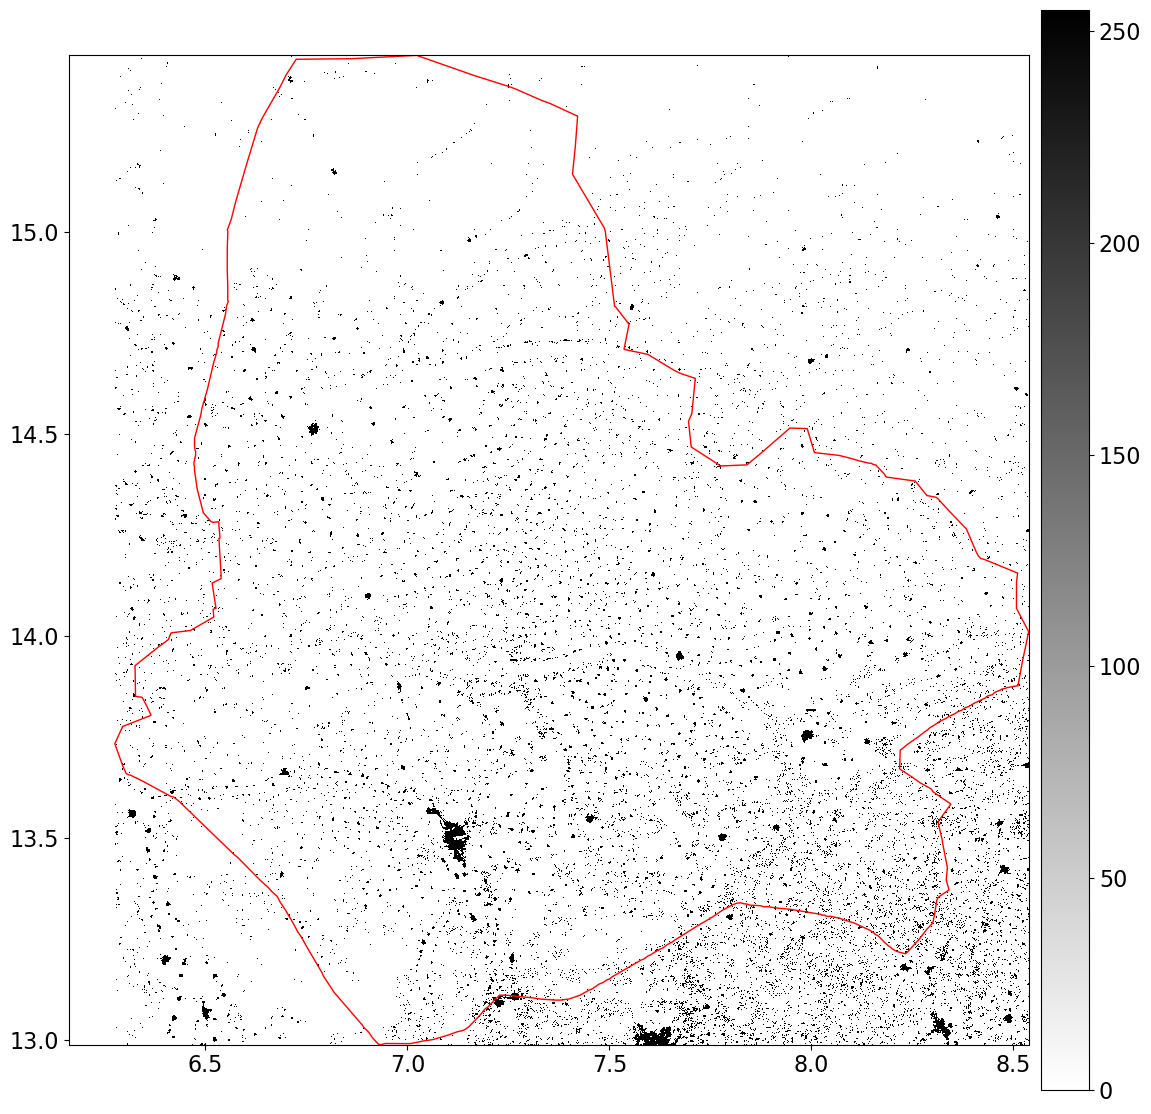

In [24]:
# for testing/visualization purposes only, we plot the warped raster

ax = gk.drawRaster(
    output_file, # the raster file that we have just created
    cmap='binary', # let us show the buildings in black and white
    srs=4326, # show in EPSG:4326, not the region mask SRS
)
# add the region shape to the plot for visualization
gk.drawGeoms(
    region_geom,
    fc=(1,1,1,0), # the last 0 means fully transparent facecolor
    ec="red", # the edges shall be colored in red
    ax=ax, # draw it into the same axis (plot) like the raster data
)

New input file: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data/exclusion_datasets//WSF2019//NER//NER.5_1_extract_WSF2019_clipped.tif
New output file: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results/NER.5_1_extract_WSF2019_clipped_resampled.tif


AxHands(ax=<Axes: >, handles=[<matplotlib.patches.PathPatch object at 0x7f8ad462be50>], cbar=None)

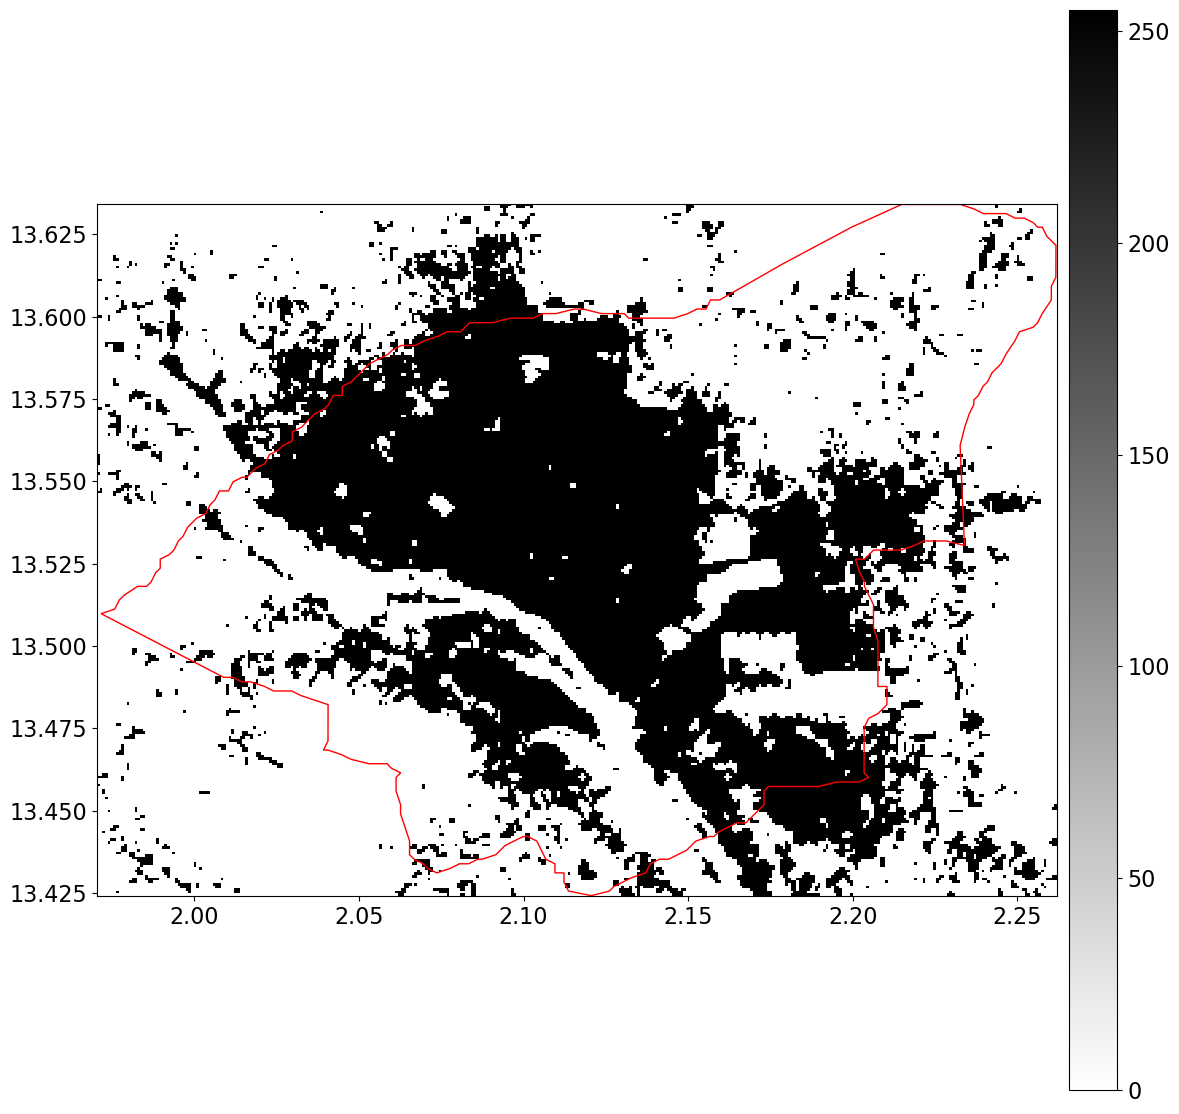

In [ ]:
# repeat the warping for a 2nd region "NER.5_1" (Niamey), it will later be needed as input for another exercise

region2 = "NER.5_1"

# generate a new regionmask with a new region geom, else the same
region_geom2 = region_df[region_df["GID_1"]==region2]["geom"].iloc[0]
rm2 = gk.RegionMask.fromGeom(
    geom=region_geom2,
    pixelRes=resolution,
    srs=gk.srs.EPSG3857,
)

# define new in- and output paths for the second region
source_file2=os.path.join(data_basefolder, WSF2019_tif.replace("COUNTRY", country).replace("REGION", region2))
print("New input file:", source_file2)

output_file2 = os.path.join(
    results_folder, 
    os.path.basename(source_file2)[:-4] + '_resampled.tif', # remove the last 4 digits from the input path ('.tif') and replace it with: '_resampled.tif'
)
print("New output file:", output_file2)

# generate the warped raster No. 2 and show what we have
rm2.warp(
    source=source_file2,
    resampleAlg='max', # choose max as resample algorithm as we wish to determine every cell as built-up with at least a single building!
    output=output_file2, # the warped data will be saved to disk as a raster file here
)
ax2 = gk.drawRaster(output_file2, cmap='binary', srs=4326) # show in EPSG:4326, not the region mask SRS
gk.drawGeoms(region_geom2, fc=(1,1,1,0), ec="red", ax=ax2) # add the region geom 2 again just like above

# NOTE: This is a great option to apply to input datafiles if you run into memory errors when calculating an LEA!

#### If this is still not sufficient, choose a coarser analysis resolution for your glaes.ExclusionCalculator object and also warp the input data to this coarser resolution first!

# NOTE: 
### This file does not have a specific task/solution. What matters is that you understand the above and execute the whole script - the produced resampled raster will be used in later exercises!